In [96]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
import seaborn as sns
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache

In [97]:
drive_dir = "/Volumes/Brain2024"
cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(cache_dir=drive_dir, use_static_cache=True)
behavior_sessions = cache.get_behavior_session_table()

Now, we want to integrate information from below few stages:
- training 3
- training 4
- training 5 ready, lapsed, epilogue.

In the end, hopefully we can include the ephys sessions.

The `strategy_summary.csv`s will be of less number of rows, compared to the total sessions. Better write a function combining them.

In [98]:
strategy_df_3 = pd.read_csv('local_modelfit/training3/strategy_summary.csv', index_col = 0)
sessions_3 =  behavior_sessions[(behavior_sessions.session_type.str.contains('TRAINING_3')) & 
                                (behavior_sessions.genotype == 'wt/wt')]

strategy_df_4 = pd.read_csv('local_modelfit/training4/strategy_summary.csv', index_col = 0)
sessions_4 =  behavior_sessions[(behavior_sessions.session_type.str.contains('TRAINING_4')) & 
                                (behavior_sessions.genotype == 'wt/wt')]

strategy_df_5_epi = pd.read_csv('local_modelfit/training5/strategy_summary_epilogue.csv', index_col = 0)
sessions_5_epi =  behavior_sessions[(behavior_sessions.session_type.str.contains('TRAINING_5')) & 
                                    (behavior_sessions.session_type.str.contains('epilogue')) & 
                                    (behavior_sessions.genotype == 'wt/wt')]

strategy_df_5_lps = pd.read_csv('local_modelfit/training5/strategy_summary_lapsed.csv', index_col = 0)
sessions_5_lps =  behavior_sessions[(behavior_sessions.session_type.str.contains('TRAINING_5')) & 
                                    (behavior_sessions.session_type.str.contains('lapsed')) & 
                                    (behavior_sessions.genotype == 'wt/wt')]

strategy_df_5_rdy = pd.read_csv('local_modelfit/training5/strategy_summary.csv', index_col = 0)
sessions_5_rdy =  behavior_sessions[(behavior_sessions.session_type.str.contains('TRAINING_5')) & 
                                    (behavior_sessions.session_type.str.contains('ready')) & 
                                    (behavior_sessions.genotype == 'wt/wt')]

In [99]:
sessions_5_epi =  behavior_sessions[
                                    (behavior_sessions.session_type.str.contains('epilogue')) & 
                                    (behavior_sessions.genotype == 'wt/wt')]

In [100]:
strategy_df_5_epi

,auc,evd,visual_index,timing_index,strategy_index
1034887215,0.779329,-1723.660502,3.229994,4.211440,-0.981445
1034659380,0.829364,-1339.459006,5.268902,3.375076,1.893827
1035085134,0.852031,-1199.044286,4.195976,8.616457,-4.420481
1032395078,0.804281,-1164.172484,6.306959,3.336257,2.970702
1033405814,0.772088,-1080.203274,6.399220,5.038890,1.360330
...,...,...,...,...,...
1117817318,0.845802,-801.905425,15.958907,3.647767,12.311140
1118300323,0.822027,-1098.441076,8.718290,8.384041,0.334249
1118496195,0.873466,-909.145550,18.617071,9.782198,8.834873
1124668180,0.887778,-643.823003,38.274979,5.588691,32.686288


In [101]:
len(strategy_df_5_epi)

174

In [104]:
import pandas as pd

def merge_strategy_with_sessions(strategy_df, sessions, stage ):
    """
    Merge strategy_df with selected columns from sessions DataFrame based on index,
    keeping only the rows where the index appears in both DataFrames.
    
    Parameters:
    strategy_df (pd.DataFrame): The strategy DataFrame
    sessions (pd.DataFrame): The sessions DataFrame containing 'mouse_id' and 'session_number'
    
    Returns:
    pd.DataFrame: Merged DataFrame
    """
    # Select only 'mouse_id' and 'session_number' from sessions
    sessions_subset = sessions[['mouse_id', 'session_number']]
    
    # Ensure both DataFrames have the same index name
    strategy_df.index.name = sessions_subset.index.name
    
    # Merge the DataFrames based on index, using an inner join
    merged_df = pd.merge(strategy_df, sessions_subset, left_index=True, right_index=True, how='inner')
    
    merged_df['stage'] = stage
    # Print information about the merge
    print(f"Original strategy_df shape: {strategy_df.shape}")
    print(f"Original sessions shape: {sessions.shape}")
    print(f"Merged DataFrame shape: {merged_df.shape}")
    print(f"Number of rows dropped: {strategy_df.shape[0] - merged_df.shape[0]}")
    
    return merged_df

# Example usage:
# merged_result = merge_strategy_with_sessions(strategy_df, sessions)

In [141]:
srategy_df_3_merged = merge_strategy_with_sessions(strategy_df_3, sessions_3, "3")
srategy_df_4_merged = merge_strategy_with_sessions(strategy_df_4, sessions_4, "4")
srategy_df_5_epi_merged = merge_strategy_with_sessions(strategy_df_5_epi, sessions_5_epi, "5_epi")
srategy_df_5_lps_merged = merge_strategy_with_sessions(strategy_df_5_lps, sessions_5_lps, "5_lapsed")
srategy_df_5_rdy_merged = merge_strategy_with_sessions(strategy_df_5_rdy, sessions_5_rdy, "5_ready")


Original strategy_df shape: (82, 5)
Original sessions shape: (82, 14)
Merged DataFrame shape: (82, 8)
Number of rows dropped: 0
Original strategy_df shape: (50, 5)
Original sessions shape: (51, 14)
Merged DataFrame shape: (50, 8)
Number of rows dropped: 0
Original strategy_df shape: (174, 5)
Original sessions shape: (93, 14)
Merged DataFrame shape: (92, 8)
Number of rows dropped: 82
Original strategy_df shape: (72, 5)
Original sessions shape: (74, 14)
Merged DataFrame shape: (72, 8)
Number of rows dropped: 0
Original strategy_df shape: (218, 5)
Original sessions shape: (222, 14)
Merged DataFrame shape: (218, 8)
Number of rows dropped: 0


In [142]:
training_df = pd.concat([srategy_df_3_merged, srategy_df_4_merged, srategy_df_5_epi_merged, srategy_df_5_lps_merged, srategy_df_5_rdy_merged], 
                        axis=0, 
                        ignore_index=True)


In [171]:
training_34_df = pd.concat([srategy_df_3_merged, srategy_df_4_merged], 
                        axis=0, 
                        ignore_index=True)


In [173]:
training_345_df = pd.concat([srategy_df_3_merged, srategy_df_4_merged, srategy_df_5_epi_merged], 
                        axis=0, 
                        ignore_index=True)


In [168]:
training_5_df = pd.concat([srategy_df_5_epi_merged, srategy_df_5_lps_merged, srategy_df_5_rdy_merged], 
                        axis=0, 
                        ignore_index=True)


In [177]:
training_5_post_df = pd.concat([srategy_df_5_lps_merged, srategy_df_5_rdy_merged], 
                        axis=0, 
                        ignore_index=True)

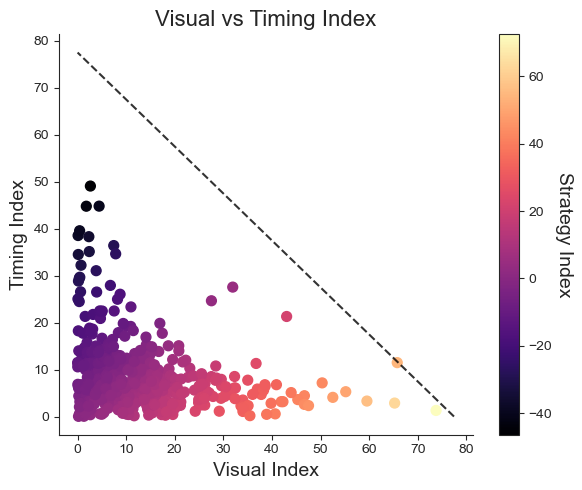

In [143]:
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(6, 5))

# Scatter plot with points colored by strategy_index
scatter = ax.scatter(x=training_df.visual_index, 
                     y=training_df.timing_index, 
                     c=training_df.strategy_index, 
                     cmap='magma', 
                     s=50, 
                     alpha=1) 

cbar = plt.colorbar(scatter)
cbar.set_label('Strategy Index', rotation=270, labelpad=15, fontsize=14)

ax.set_xlabel('Visual Index', fontsize=14)
ax.set_ylabel('Timing Index', fontsize=14)
ax.set_title('Visual vs Timing Index', fontsize=16)

max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot([max_val, 0], [0, max_val], 'k--', alpha=0.8)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [144]:
# Check if there are any NaN values in strategy_df
has_nan = training_df.isna().any().any()

if has_nan:
    print("strategy_df contains NaN values.")
    
    # Get columns with NaN values
    columns_with_nan = training_df.columns[training_df.isna().any()].tolist()
    print(f"Columns containing NaN values: {columns_with_nan}")
    
    # Get count of NaN values in each column
    nan_counts = training_df.isna().sum()
    print("\nCount of NaN values in each column:")
    print(nan_counts[nan_counts > 0])
    
    # Get rows with NaN values
    rows_with_nan = training_df.index[training_df.isna().any(axis=1)].tolist()
    print(f"\nIndices of rows containing NaN values: {rows_with_nan}")
    
    # Display a few rows with NaN as an example
    print("\nExample rows containing NaN values:")
    print(training_df[training_df.isna().any(axis=1)].head())
else:
    print("strategy_df does not contain any NaN values.")

strategy_df does not contain any NaN values.


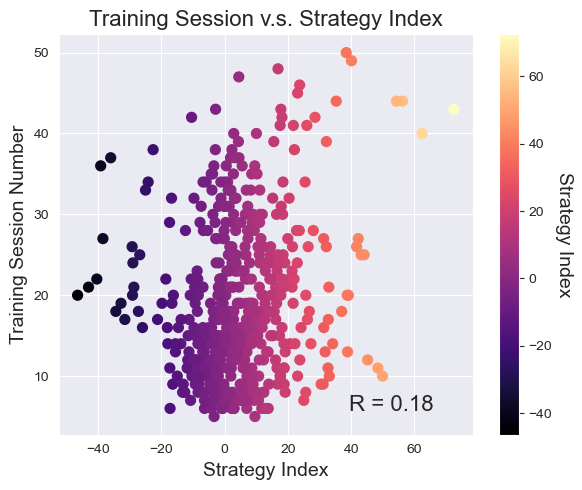

In [169]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(6, 5))


r = np.corrcoef(training_df['session_number'], training_df['strategy_index'])

# Scatter plot with points colored by strategy_index
scatter = ax.scatter(x=training_df.strategy_index, 
                     y=training_df.session_number, 
                     c=training_df.strategy_index, 
                     cmap='magma', 
                     s=50, 
                     alpha=1) 

cbar = plt.colorbar(scatter)
cbar.set_label('Strategy Index', rotation=270, labelpad=15, fontsize=14)

ax.set_xlabel('Strategy Index', fontsize=14)
ax.set_ylabel('Training Session Number', fontsize=14)
ax.set_title('Training Session v.s. Strategy Index', fontsize=16)

ax.text(0.70, 0.10, f'R = {r[0, 1]:.2f}', fontsize=16, 
        transform=ax.transAxes, verticalalignment='top')
plt.tight_layout()
plt.show()

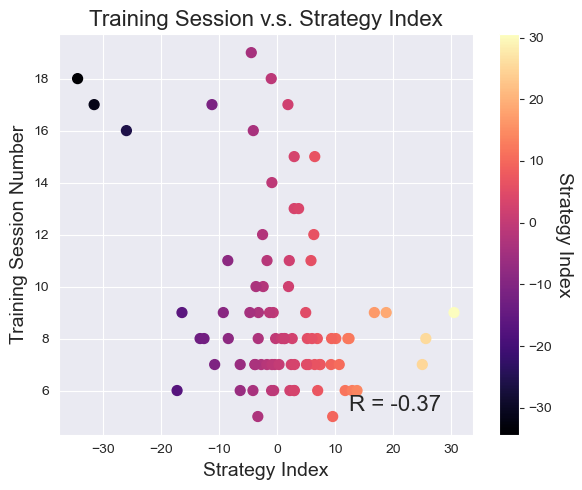

In [175]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(6, 5))


r = np.corrcoef(srategy_df_3_merged['session_number'], srategy_df_3_merged['strategy_index'])

# Scatter plot with points colored by strategy_index
scatter = ax.scatter(x=srategy_df_3_merged.strategy_index, 
                     y=srategy_df_3_merged.session_number, 
                     c=srategy_df_3_merged.strategy_index, 
                     cmap='magma', 
                     s=50, 
                     alpha=1) 

cbar = plt.colorbar(scatter)
cbar.set_label('Strategy Index', rotation=270, labelpad=15, fontsize=14)

ax.set_xlabel('Strategy Index', fontsize=14)
ax.set_ylabel('Training Session Number', fontsize=14)
ax.set_title('Training Session v.s. Strategy Index', fontsize=16)

ax.text(0.70, 0.10, f'R = {r[0, 1]:.2f}', fontsize=16, 
        transform=ax.transAxes, verticalalignment='top')
plt.tight_layout()
plt.show()

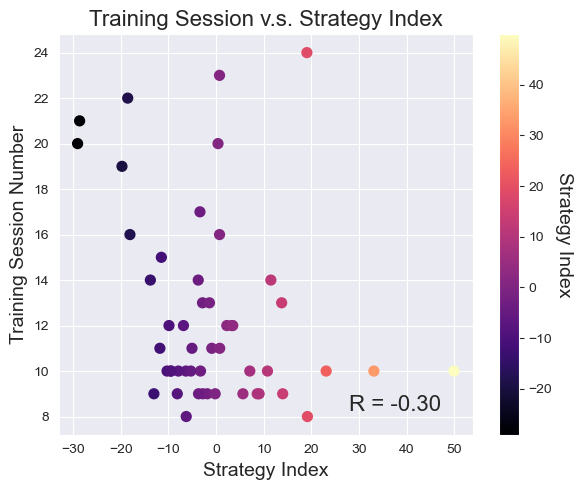

In [176]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(6, 5))


r = np.corrcoef(srategy_df_4_merged['session_number'], srategy_df_4_merged['strategy_index'])

# Scatter plot with points colored by strategy_index
scatter = ax.scatter(x=srategy_df_4_merged.strategy_index, 
                     y=srategy_df_4_merged.session_number, 
                     c=srategy_df_4_merged.strategy_index, 
                     cmap='magma', 
                     s=50, 
                     alpha=1) 

cbar = plt.colorbar(scatter)
cbar.set_label('Strategy Index', rotation=270, labelpad=15, fontsize=14)

ax.set_xlabel('Strategy Index', fontsize=14)
ax.set_ylabel('Training Session Number', fontsize=14)
ax.set_title('Training Session v.s. Strategy Index', fontsize=16)

ax.text(0.70, 0.10, f'R = {r[0, 1]:.2f}', fontsize=16, 
        transform=ax.transAxes, verticalalignment='top')
plt.tight_layout()
plt.show()

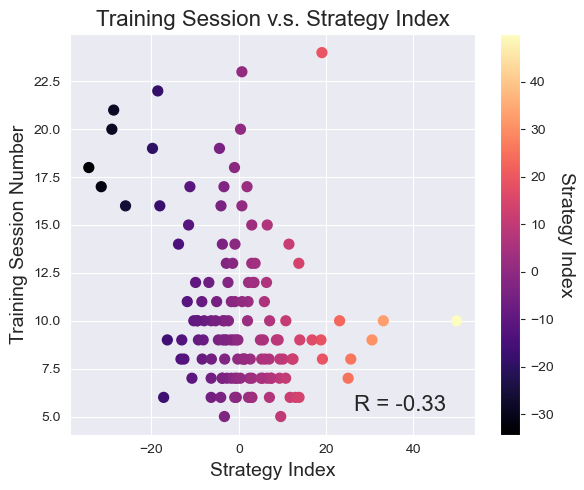

In [172]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(6, 5))


r = np.corrcoef(training_34_df['session_number'], training_34_df['strategy_index'])

# Scatter plot with points colored by strategy_index
scatter = ax.scatter(x=training_34_df.strategy_index, 
                     y=training_34_df.session_number, 
                     c=training_34_df.strategy_index, 
                     cmap='magma', 
                     s=50, 
                     alpha=1) 

cbar = plt.colorbar(scatter)
cbar.set_label('Strategy Index', rotation=270, labelpad=15, fontsize=14)

ax.set_xlabel('Strategy Index', fontsize=14)
ax.set_ylabel('Training Session Number', fontsize=14)
ax.set_title('Training Session v.s. Strategy Index', fontsize=16)

ax.text(0.70, 0.10, f'R = {r[0, 1]:.2f}', fontsize=16, 
        transform=ax.transAxes, verticalalignment='top')
plt.tight_layout()
plt.show()

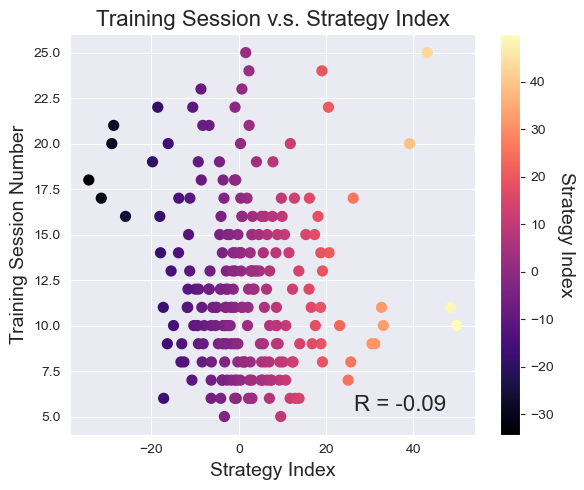

In [174]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(6, 5))


r = np.corrcoef(training_345_df['session_number'], training_345_df['strategy_index'])

# Scatter plot with points colored by strategy_index
scatter = ax.scatter(x=training_345_df.strategy_index, 
                     y=training_345_df.session_number, 
                     c=training_345_df.strategy_index, 
                     cmap='magma', 
                     s=50, 
                     alpha=1) 

cbar = plt.colorbar(scatter)
cbar.set_label('Strategy Index', rotation=270, labelpad=15, fontsize=14)

ax.set_xlabel('Strategy Index', fontsize=14)
ax.set_ylabel('Training Session Number', fontsize=14)
ax.set_title('Training Session v.s. Strategy Index', fontsize=16)

ax.text(0.70, 0.10, f'R = {r[0, 1]:.2f}', fontsize=16, 
        transform=ax.transAxes, verticalalignment='top')
plt.tight_layout()
plt.show()

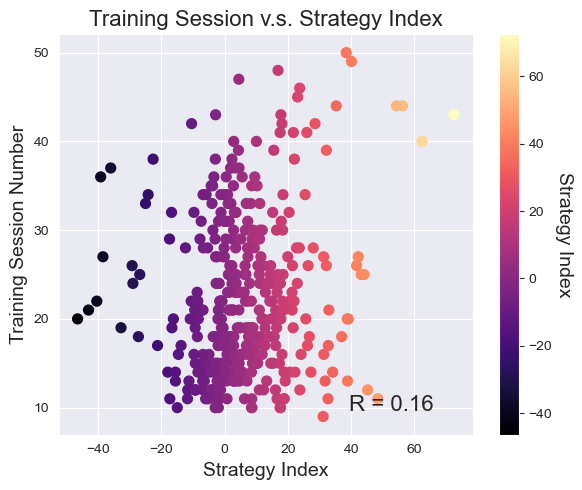

In [170]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(6, 5))


r = np.corrcoef(training_5_df['session_number'], training_5_df['strategy_index'])

# Scatter plot with points colored by strategy_index
scatter = ax.scatter(x=training_5_df.strategy_index, 
                     y=training_5_df.session_number, 
                     c=training_5_df.strategy_index, 
                     cmap='magma', 
                     s=50, 
                     alpha=1) 

cbar = plt.colorbar(scatter)
cbar.set_label('Strategy Index', rotation=270, labelpad=15, fontsize=14)

ax.set_xlabel('Strategy Index', fontsize=14)
ax.set_ylabel('Training Session Number', fontsize=14)
ax.set_title('Training Session v.s. Strategy Index', fontsize=16)

ax.text(0.70, 0.10, f'R = {r[0, 1]:.2f}', fontsize=16, 
        transform=ax.transAxes, verticalalignment='top')
plt.tight_layout()
plt.show()

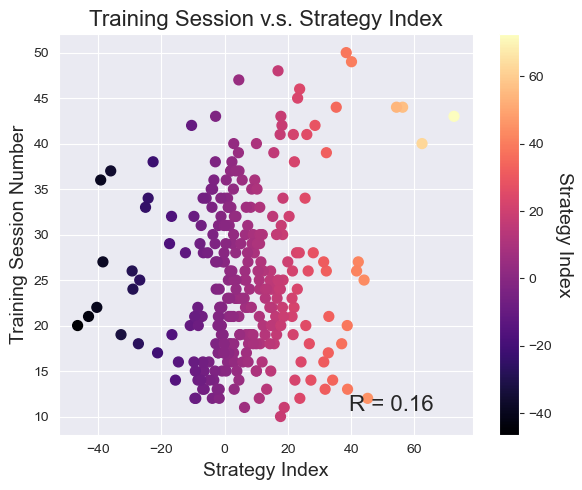

In [178]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(6, 5))


r = np.corrcoef(training_5_post_df['session_number'], training_5_post_df['strategy_index'])

# Scatter plot with points colored by strategy_index
scatter = ax.scatter(x=training_5_post_df.strategy_index, 
                     y=training_5_post_df.session_number, 
                     c=training_5_post_df.strategy_index, 
                     cmap='magma', 
                     s=50, 
                     alpha=1) 

cbar = plt.colorbar(scatter)
cbar.set_label('Strategy Index', rotation=270, labelpad=15, fontsize=14)

ax.set_xlabel('Strategy Index', fontsize=14)
ax.set_ylabel('Training Session Number', fontsize=14)
ax.set_title('Training Session v.s. Strategy Index', fontsize=16)

ax.text(0.70, 0.10, f'R = {r[0, 1]:.2f}', fontsize=16, 
        transform=ax.transAxes, verticalalignment='top')
plt.tight_layout()
plt.show()

In [182]:
# Sort the DataFrame by mouse_id and session_number in descending order
training_5_post_df_sorted = training_5_df.sort_values(['mouse_id', 'session_number'], ascending=[True, False])

# Group by mouse_id and select the top 2 rows for each group
training_5_post_latest_two = training_5_post_df_sorted.groupby('mouse_id').head(2).reset_index(drop=True)

# Print information about the original and resulting DataFrames
print(f"Original DataFrame shape: {training_5_post_df.shape}")
print(f"Latest two sessions DataFrame shape: {training_5_post_latest_two.shape}")

# Optional: Check if all mice have at least two sessions
mice_session_counts = training_5_post_latest_two['mouse_id'].value_counts()
mice_with_one_session = mice_session_counts[mice_session_counts == 1].index.tolist()

if mice_with_one_session:
    print(f"Note: The following mice have only one session in the result: {mice_with_one_session}")
else:
    print("All mice in the result have two sessions.")

# Display the first few rows of the result
print("\nFirst few rows of the resulting DataFrame:")
print(training_5_post_latest_two.head())

Original DataFrame shape: (290, 8)
Latest two sessions DataFrame shape: (54, 8)
All mice in the result have two sessions.

First few rows of the resulting DataFrame:
        auc          evd  visual_index  timing_index  strategy_index  \
0  0.783889  -731.812916     38.908493      0.467441       38.441052   
1  0.819315  -762.170090     40.670853      0.564109       40.106744   
2  0.815313 -1125.703091     24.068886      5.611898       18.456987   
3  0.794860 -1396.643418     13.738624      5.478539        8.260085   
4  0.874346  -880.531732     13.222732     11.147075        2.075657   

   mouse_id  session_number    stage  
0    524760              50  5_ready  
1    524760              49  5_ready  
2    524761              34  5_ready  
3    524761              33  5_ready  
4    531237              37  5_ready  


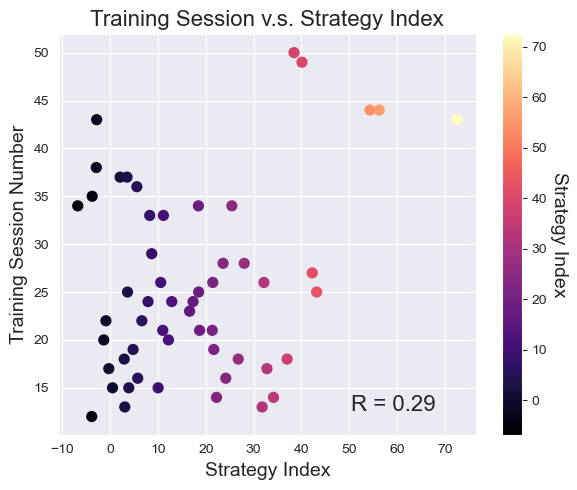

In [183]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(6, 5))


r = np.corrcoef(training_5_post_latest_two['session_number'], training_5_post_latest_two['strategy_index'])

# Scatter plot with points colored by strategy_index
scatter = ax.scatter(x=training_5_post_latest_two.strategy_index, 
                     y=training_5_post_latest_two.session_number, 
                     c=training_5_post_latest_two.strategy_index, 
                     cmap='magma', 
                     s=50, 
                     alpha=1) 

cbar = plt.colorbar(scatter)
cbar.set_label('Strategy Index', rotation=270, labelpad=15, fontsize=14)

ax.set_xlabel('Strategy Index', fontsize=14)
ax.set_ylabel('Training Session Number', fontsize=14)
ax.set_title('Training Session v.s. Strategy Index', fontsize=16)

ax.text(0.70, 0.10, f'R = {r[0, 1]:.2f}', fontsize=16, 
        transform=ax.transAxes, verticalalignment='top')
plt.tight_layout()
plt.show()

In [146]:
session_df = training_df

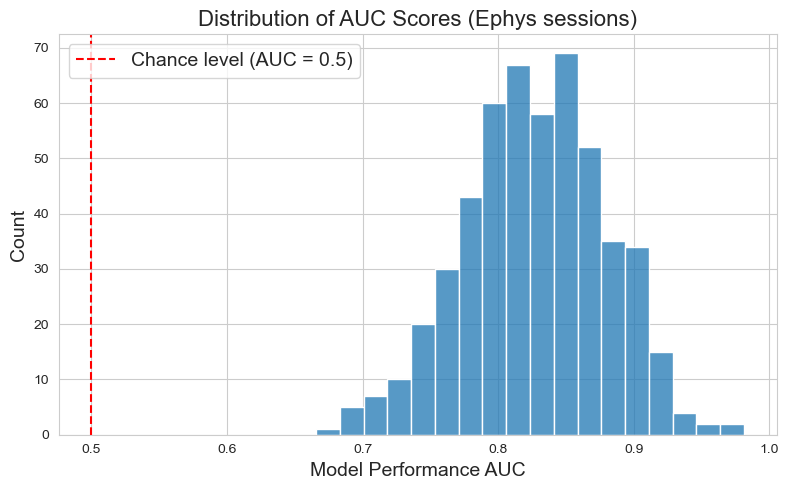

In [152]:
# AUC plot

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize = [8, 5])
sns.histplot(session_df.auc)
ax.axvline(x=0.5, color='red', linestyle='--', label='Chance level (AUC = 0.5)')

plt.title('Distribution of AUC Scores (Ephys sessions)', fontsize=16)
plt.xlabel('Model Performance AUC', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.legend(fontsize = 14)

plt.tight_layout()
plt.show()

In [147]:
# Calculate the average strategy index for each mouse
mouse_avg = session_df.groupby('mouse_id')['strategy_index'].mean().sort_values()
# Create a dictionary mapping mouse_id to average strategy index
mouse_avg_dict = mouse_avg.to_dict()
# Add a new column with the average strategy index for each mouse
session_df['avg_strategy_index'] = session_df['mouse_id'].map(mouse_avg_dict)
# Sort the DataFrame by the average strategy index
session_df_sorted_by_avg = session_df.sort_values('avg_strategy_index')

/var/folders/45/vxs3qxtn0ql1mmj2dm1w3zxw0000gp/T/ipykernel_89027/617004591.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('magma')


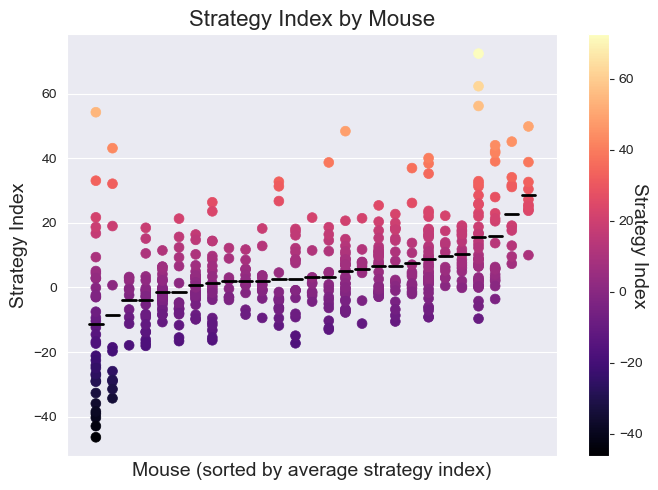

In [148]:
fig, ax = plt.subplots(figsize=(7, 5))

# Get unique mouse IDs in the sorted order
unique_mice = session_df_sorted_by_avg['mouse_id'].unique()

# Create a color palette
palette = plt.cm.get_cmap('magma')

# Set up normalization for color mapping
norm = plt.Normalize(session_df_sorted_by_avg['strategy_index'].min(), 
                     session_df_sorted_by_avg['strategy_index'].max())

# Plot each session as a point
for i, mouse in enumerate(unique_mice):
    mouse_data = session_df_sorted_by_avg[session_df_sorted_by_avg['mouse_id'] == mouse]
    scatter = ax.scatter([i] * len(mouse_data), mouse_data['strategy_index'], 
                         c=mouse_data['strategy_index'], cmap=palette, norm=norm,
                         s=50, edgecolor=None, linewidth=0.5)

# Add horizontal lines at y=0 and average strategy index for each mouse
# ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
for i, mouse in enumerate(unique_mice):
    avg_index = mouse_avg[mouse]
    ax.plot([i-0.4, i+0.4], [avg_index, avg_index], color='black', linewidth=2)

ax.set_xlabel('Mouse (sorted by average strategy index)', fontsize=14)
ax.set_ylabel('Strategy Index', fontsize=14)
ax.set_title('Strategy Index by Mouse', fontsize=16)
ax.set_xticks([])  # remove x-axis ticks

cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Strategy Index', rotation=270, fontsize = 14)

plt.tight_layout()
plt.show()

In [149]:
session_df_sorted_by_avg['session_number'].max()

50

/var/folders/45/vxs3qxtn0ql1mmj2dm1w3zxw0000gp/T/ipykernel_89027/3275178281.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('viridis')


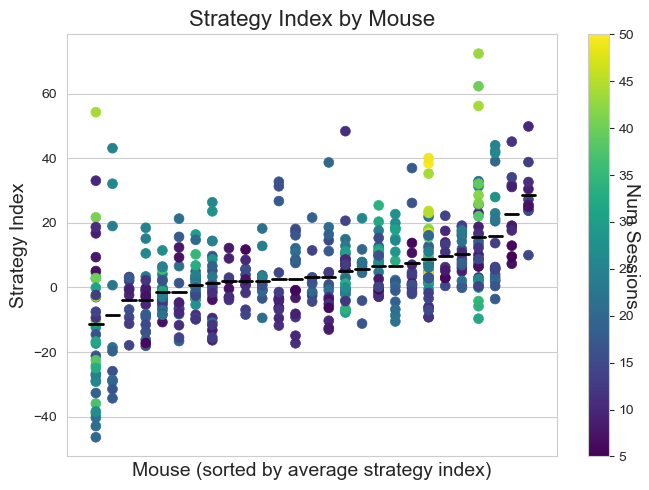

In [159]:
fig, ax = plt.subplots(figsize=(7, 5))

# Get unique mouse IDs in the sorted order
unique_mice = session_df_sorted_by_avg['mouse_id'].unique()

# Create a color palette
palette = plt.cm.get_cmap('viridis')

# Set up normalization for color mapping
norm = plt.Normalize(session_df_sorted_by_avg['session_number'].min(), 
                     session_df_sorted_by_avg['session_number'].max())

# Plot each session as a point
for i, mouse in enumerate(unique_mice):
    mouse_data = session_df_sorted_by_avg[session_df_sorted_by_avg['mouse_id'] == mouse]
    scatter = ax.scatter([i] * len(mouse_data), mouse_data['strategy_index'], 
                         c=mouse_data['session_number'], norm = norm, cmap = palette,
                         s=50, edgecolor=None, linewidth=0.5)

# Add horizontal lines at y=0 and average strategy index for each mouse
# ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
for i, mouse in enumerate(unique_mice):
    avg_index = mouse_avg[mouse]
    ax.plot([i-0.4, i+0.4], [avg_index, avg_index], color='black', linewidth=2)

ax.set_xlabel('Mouse (sorted by average strategy index)', fontsize=14)
ax.set_ylabel('Strategy Index', fontsize=14)
ax.set_title('Strategy Index by Mouse', fontsize=16)
ax.set_xticks([])  # remove x-axis ticks

cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Num Sessions', rotation=270, fontsize = 14)

plt.tight_layout()
plt.show()

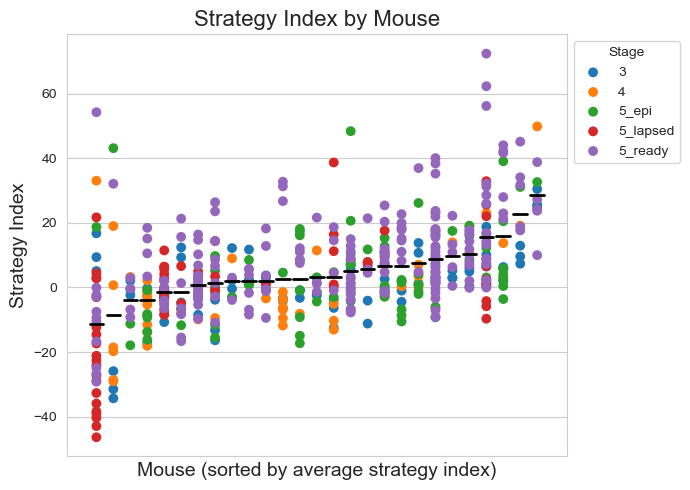

In [162]:
fig, ax = plt.subplots(figsize=(7, 5))

# Get unique mouse IDs in the sorted order
unique_mice = session_df_sorted_by_avg['mouse_id'].unique()

# Define colors for stages
stage_colors = {'3': 'C0', '4': 'C1', '5_epi': 'C2', '5_lapsed': 'C3', '5_ready': 'C4'}

# Plot each session as a point
for i, mouse in enumerate(unique_mice):
    mouse_data = session_df_sorted_by_avg[session_df_sorted_by_avg['mouse_id'] == mouse]
    for stage, color in stage_colors.items():
        stage_data = mouse_data[mouse_data['stage'] == stage]
        ax.scatter([i] * len(stage_data), stage_data['strategy_index'], 
                   c=color, label=stage if i == 0 else "", 
                   s=50, edgecolor='none')

# Add horizontal lines at average strategy index for each mouse
for i, mouse in enumerate(unique_mice):
    avg_index = mouse_avg[mouse]
    ax.plot([i-0.4, i+0.4], [avg_index, avg_index], color='black', linewidth=2)

ax.set_xlabel('Mouse (sorted by average strategy index)', fontsize=14)
ax.set_ylabel('Strategy Index', fontsize=14)
ax.set_title('Strategy Index by Mouse', fontsize=16)
ax.set_xticks([])  # remove x-axis ticks

# Add legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title='Stage', 
          loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()